In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def load_mnist(batch_size=128, root='datasets/'):
    compose = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((.5,), (.5,))
                                 ])
    train_dataset = torchvision.datasets.MNIST(root=root, train=True,
                                              transform=compose, download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader

In [0]:
class Generator(nn.Module):
    def __init__(self, data_dim, hid_dim, z_dim):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hid_dim, data_dim),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.layers(x)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, data_dim, hid_dim):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(data_dim, hid_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hid_dim, hid_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hid_dim, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.layers(x)

In [0]:
def losses(DG, DR, eps=1e-6):
    D_loss = torch.log(DR + eps) + torch.log(1 - DG + eps)
    # G_loss = torch.log(DG + eps) + torch.log(1 - DR + eps)
    G_loss = torch.log(DG + eps)

    return -torch.mean(D_loss), -torch.mean(G_loss)

In [0]:
def init_weights(Layer):
    name = Layer.__class__.__name__
    if name == 'Linear':
        torch.nn.init.normal_(Layer.weight, mean=0, std=0.01)
        if Layer.bias is not None:
            torch.nn.init.constant_(Layer.bias, 0)

In [0]:
mnist_loader = load_mnist()

In [0]:
n_epochs = 1000
l_rate = 1e-4

z_dim = 64
hid_dim = 1024
data_shape = mnist_loader.dataset.data.shape
data_dim = data_shape[1] * data_shape[2]

G = Generator(data_dim, hid_dim, z_dim).to(device)
D = Discriminator(data_dim, hid_dim).to(device)

G.apply(init_weights)
D.apply(init_weights)

optim_G = torch.optim.Adam(G.parameters(), lr=l_rate)
optim_D = torch.optim.Adam(D.parameters(), lr=l_rate)

Epoch: 0 D_loss: 0.6931519549030231 G_loss: 0.6931374313226387


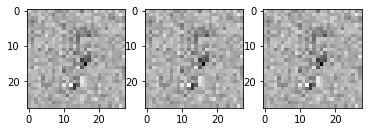

Epoch: 1 D_loss: 0.6931507487032713 G_loss: 0.6931386368869464


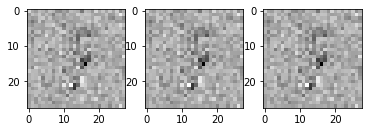

Epoch: 2 D_loss: 0.693150214930333 G_loss: 0.693139162399113


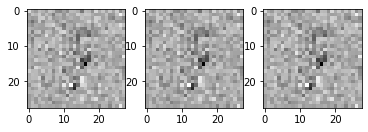

Epoch: 3 D_loss: 0.6931494249463844 G_loss: 0.6931399489516643


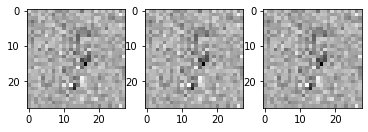

Epoch: 4 D_loss: 0.693149016991353 G_loss: 0.6931403534752982


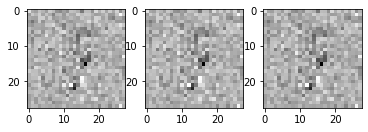

Epoch: 5 D_loss: 0.6931485458731905 G_loss: 0.6931408239580167


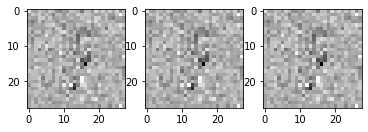

Epoch: 6 D_loss: 0.693147861754208 G_loss: 0.6931415046456018


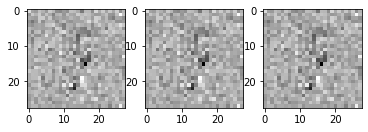

Epoch: 7 D_loss: 0.6931474245687538 G_loss: 0.6931419400518128


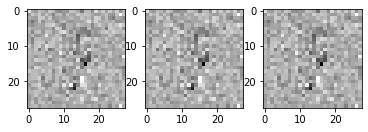

Epoch: 8 D_loss: 0.6931470497838979 G_loss: 0.6931423126761593


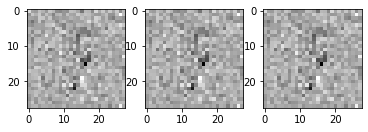

Epoch: 9 D_loss: 0.6931467282492468 G_loss: 0.6931426340837215


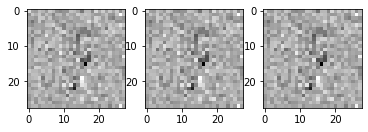

Epoch: 10 D_loss: 0.6931462464556257 G_loss: 0.6931431152418986


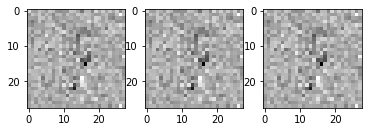

KeyboardInterrupt: ignored

In [38]:
for i in range(n_epochs):
    D_loss_acc = 0.
    G_loss_acc = 0.
    for j, (batch, _) in enumerate(mnist_loader):
        n_samples = batch.shape[0]
        images = batch.reshape(n_samples, -1).to(device)

        z = 2 * torch.rand(n_samples, z_dim).to(device) - 1

        Gz = G(z)
        DG = D(Gz)
        DR = D(images)

        D_loss, G_loss = losses(DG, DR)
        
        D_loss_acc += D_loss.item()
        G_loss_acc += G_loss.item()

        optim_D.zero_grad()
        optim_G.zero_grad()

        D_loss.backward(retain_graph=True)
        G_loss.backward()

        optim_D.step()
        optim_G.step()

    G.eval()
    with torch.no_grad():
        z = 2 * torch.rand(3, z_dim).to(device) - 1
        Gz = G(z)

        print(f'Epoch: {i} D_loss: {D_loss_acc / (j+1) } G_loss: {G_loss_acc / (j+1) }')
        fig, (ax0, ax1, ax2) = plt.subplots(1,3)
        ax0.imshow(Gz[0].reshape(data_shape[1:]).cpu().numpy(), cmap='gray')
        ax1.imshow(Gz[1].reshape(data_shape[1:]).cpu().numpy(), cmap='gray')
        ax2.imshow(Gz[2].reshape(data_shape[1:]).cpu().numpy(), cmap='gray')
        plt.show()